# Detection & contrast estimation of the proteins in iSCAT videos 

## Previously on PiSCAT tutorials...
Previously, we demonstrated how to use PiSCAT's APIs for [setting up the PiSCAT modules and downloading a demo iSCAT video](Tutorial1.ipynb#Setting-up-the-PiSCAT-modules-and-downloading-a-demo-iSCAT-video), [performing basic checks on the acquisition process](Tutorial1.ipynb#Examining-the-status-line-&-removing-it) and [basic data visualization](Tutorial1.ipynb#Display-and-inspect-a-loaded-video). Based on number of available CPU cores for parallel processing, this tutorial needs 15-20 GB computer memory (RAM) to run.

In [2]:
# Only to ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Setting up the path to the PiSCAT modules
import os
import sys
current_path = os.path.abspath(os.path.join('..'))
dir_path = os.path.dirname(current_path)
module_path = os.path.join(dir_path)
if module_path not in sys.path:
    sys.path.append(module_path)
     
# Downloading a measurement video for this tutorial 
from piscat.InputOutput import download_tutorial_data
download_tutorial_data('Tutorial3_video')

# Examining the status line in a loaded/downloaded video and removing the line
from piscat.InputOutput import reading_videos
from piscat.Visualization import JupyterDisplay,JupyterSubplotDisplay 
from piscat.InputOutput import read_status_line
from piscat.Preproccessing import normalization
from piscat.BackgroundCorrection import DifferentialRollingAverage
import numpy as np

data_path = os.path.join(dir_path, 'Tutorials', 'Demo data', 'Tutorial3', 'Tutorial3_1')#The path to the measurement data
df_video = reading_videos.DirectoryType(data_path, type_file='raw').return_df()
paths = df_video['Directory'].tolist()
video_names = df_video['File'].tolist()
demo_video_path = os.path.join(paths[0], video_names[0])#Selecting the first entry in the list
video = reading_videos.video_reader(file_name=demo_video_path, type='binary', img_width=128, img_height=128, 
                                    image_type=np.dtype('<u2'), s_frame=0, e_frame=-1)#Loading the video
status_ = read_status_line.StatusLine(video)#Reading the status line
video_remove_status, status_information  = status_.find_status_line()#Examining the status line & removing it


Directory  D:\piscat_public\PiSCAT\Tutorials  already exists

The directory with the name  Demo data  already exists in the following path: D:\piscat_public\PiSCAT\Tutorials
Directory  Tutorial3  already exists!

Directory  Histogram  already exists
---Status line detected in column---


## Dark frame correction
The gray values of an iSCAT image can be directly used to quantitatively estimate the mass of the detected proteins.
 The read-out digital value of a pixel, however, is not entirely built from the collected photons. Part of the recorded signal stems from an extra offset voltage that exists even in imaging under no light condition. We, therefore, need to perform an additional preprocessing step on iSCAT videos to subtract a calibrating dark frame from every recorded frame. The dark count in the read-out value of a pixel is a function of acquisition parameters such as exposure time, frame rate and etc. The dark frame correction of iSCAT videos would allow us to obtain the accurate contrasts of the proteins i.e. the true contrast value in
an absolute sense which is independent of the acquisition parameters. In the following cell, we first compute the pixel-wise average of a calibrating dark video to form the mean dark frame and then subtract this frame from the protein measurement videos. 

In [3]:
data_path = os.path.join(dir_path, 'Tutorials', 'Demo data', 'Tutorial3', 'Tutorial3_2')#The path to the dark video data
df_video = reading_videos.DirectoryType(data_path, type_file='raw').return_df()
paths = df_video['Directory'].tolist()
video_names = df_video['File'].tolist()
demo_video_path = os.path.join(paths[0], video_names[0])#Selecting the first entry in the list
video_darkFrames = reading_videos.video_reader(file_name=demo_video_path, type='binary', img_width=128, img_height=128, 
                                    image_type=np.dtype('<u2'), s_frame=0, e_frame=-1)#Loading the video
status_ = read_status_line.StatusLine(video_darkFrames)#Reading the status line
video_darkFrames_remove_status, status_information  = status_.find_status_line()#Examining the status line & removing it
mean_dark_frame = np.mean(video_darkFrames_remove_status, axis=0)#Computing the mean of the video
video_remove_status_dc = np.subtract(video_remove_status, mean_dark_frame)#Subtracting the mean dark frame from the measurement 

#Visualization of iSCAT frames before and after correction of dark counts
list_titles=['Raw video', 
             'Video after \ndark frame correction',
            'Difference']

from piscat.Visualization.display_jupyter import JupyterSubplotDisplay
# For Jupyter notebooks only:
%matplotlib inline
JupyterSubplotDisplay(list_videos=[video_remove_status, video_remove_status_dc, 
                                       video_remove_status - video_remove_status_dc], 
                    numRows=1, numColumns=3, list_titles=list_titles, imgSizex=15, imgSizey=5, IntSlider_width='500px',
                    median_filter_flag=False, color='gray')

---Status line detected in column---


interactive(children=(IntSlider(value=0, continuous_update=False, description='Frame:', layout=Layout(width='5…

Next, we perform [power normalization to suppress the temporal instability of the laser light](Tutorial1.ipynb#Normalization-of-the-power-in-the-frames-of-a-video) and [DRA](Tutorial2.ipynb#Frame-averaging-to-boost-SNR-of-imaged-proteins,-followed-by-visualization-of-their-signal-via-differential-imaging) with a batch size of 500 frames.  

In [4]:
#From previous tutorials: power normalization, DRA
video_pn, _ = normalization.Normalization(video=video_remove_status_dc).power_normalized()
video_pn = video_remove_status_dc
batchSize = 500
DRA_PN = DifferentialRollingAverage(video=video_pn, batchSize=batchSize)
RVideo_PN = DRA_PN.differential_rolling(FFT_flag=False)


start power_normalized without parallel loop---> Done

--- start DRA ---


  0%|          | 0/18999 [00:00<?, ?it/s]

## Localization of proteins:
In this section, we directly work with the dynamic features that are remained in the DRA videos. As mentioned earlier the system response of a wide-field microscope for weakly scattering objects can be well approximated with a 2D Gaussian function. There exist a variety of localization algorithms available in the localization toolbox of PiSCAT. Difference of Gaussian ([DoG](https://piscat.readthedocs.io/en/latest/code_reference.html#piscat.Localization.PSFsExtraction.psf_detection)) algorithm, for example, is suitable to perform a very efficient localization of proteins with pixel precision particle localization.

In the following cell, a DRA video is being processed with a suitable set of parameters. The minima and maxima of the sigma values for the DoG kernels are lower and upper limits of the PSF size (in pixels) that one expects once the microscope response function is approximated with a 2D Gaussian function. The sigma ratio and the threshold values in this cell are set with respect to the contrast of the particles we are seeking to detect. We begin this analysis by presenting an interactive PiSCAT class that enables us to tune the DoG detection parameter and visualizes the localized particles dynamically.   

In [5]:
from piscat.Localization import particle_localization

PSF_l = particle_localization.PSFsExtraction(video=RVideo_PN)
PSFs = PSF_l.psf_detection_preview(function='dog',  
                            min_sigma=1.6, max_sigma=1.7, sigma_ratio=1.1, threshold=1.5e-4,
                            overlap=0, mode='BOTH', frame_number=[500, 7385])

interactive(children=(FloatSlider(value=0.00015, continuous_update=False, description='Threshold', layout=Layo…

Once we get to a working set of parameters for our localization algorithm we run the detection algorithm for all the frames of the video. 

In [6]:
PSFs_dog = PSF_l.psf_detection(function='dog', 
                            min_sigma=1.6, max_sigma=1.7, sigma_ratio=1.1, threshold=1.5e-4,
                            overlap=0, mode='BOTH')


---start PSF detection with parallel loop---


  0%|          | 0/19000 [00:00<?, ?it/s]

Detected particles are listed in a Panda data frame named as `PSFs_dog`. The information stored in this data structure is printed in the following,

In [7]:
PSFs_dog

,y,x,frame,center_intensity,sigma
0,15.0,6.0,0,-0.001362,1.6
1,30.0,104.0,0,-0.002936,1.6
2,99.0,11.0,0,-0.004625,1.6
3,102.0,8.0,0,-0.001364,1.6
4,116.0,8.0,0,-0.001927,1.6
...,...,...,...,...,...
131851,46.0,7.0,18999,-0.001506,1.6
131852,105.0,39.0,18999,-0.002903,1.6
131853,109.0,3.0,18999,-0.000172,1.6
131854,114.0,71.0,18999,-0.002101,1.6


### Filtering of DRA frames prior to the localization of particles with band-pass filters and/or Radial Variance Treansform ([1](https://doi.org/10.1364/OE.420670))
Further filtering of DRA frames would facilitate even more robust localization of particles.
This could be, for example, a simple image conditioning routine such as a high-pass Fourier filter which can easily remove large features in the image due to lateral instability of the illumination profile.
In some other cases, while imaging relatively large proteins (bigger than 120KDa), we would have prominent sidelobes in the recorded PSFs. Such proteins have a very strong radially symmetric signature 
that can be exploited in order to tell the particles apart from the other features in the image. In the following cell, we demonstrate the application of [Radial Variance Treansform (RVT) filtering functionality](https://piscat.readthedocs.io/en/latest/code_reference.html#piscat.Preproccessing.RadialVarianceTransform) on the iSCAT images together with the DoG particle localizer.
As demonstrated in the following cell, with the application of such filters to the images one would need to re-tune the DoG localization parameters.  

In [8]:
# Step1- Localize particles one more time with RVT. 
from piscat.Preproccessing import filtering
rvt_ = filtering.RadialVarianceTransform(inter_flag_parallel_active=False)
filtered_video = rvt_.rvt_video(video=RVideo_PN, rmin=2, rmax=3, kind="basic", highpass_size=None,
            upsample=1, rweights=None, coarse_factor=1, coarse_mode='add',
            pad_mode='constant')
    
# Step2- Just as before we deploy DoG localization algorithm but this time on the filtered DRA video 
PSF_localized_rvt = particle_localization.PSFsExtraction(video=filtered_video, flag_transform=True)
PSFs_RVT_dog = PSF_localized_rvt.psf_detection(function='dog',  
                            min_sigma=1.6, max_sigma=1.7, sigma_ratio=1.1, threshold=1.2e-8,
                            overlap=0, mode='BOTH')

# Step3- Visualization of Localized proteins in the DRA videos with DoG with and without RVT filtering on the left and right correspondingly  
from piscat.Visualization import JupyterPSFs_subplotLocalizationDisplay
JupyterPSFs_subplotLocalizationDisplay(list_videos=[RVideo_PN, filtered_video], list_df_PSFs=[PSFs_dog, PSFs_RVT_dog], 
                                    numRows=1, numColumns=2, list_titles=['DoG', 'RVT'], median_filter_flag=False, 
                                       color='gray', imgSizex=15, imgSizey=15, IntSlider_width='400px', step=1, value=11931)

# Alternatively: We can perform both the processes of steps 1 and 2 together efficiently:
PSF_l = particle_localization.PSFsExtraction(video=RVideo_PN, flag_transform=False)
PSFs_RVT = PSF_l.psf_detection(function='RVT', 
                            min_radial=2, max_radial=3,  rvt_kind="basic", 
                            highpass_size=None, upsample=1, rweights=None, coarse_factor=1, coarse_mode="add",
                            pad_mode="constant", threshold=1.5e-7)


---start RVT without Parallel---


  0%|          | 0/19000 [00:00<?, ?it/s]


---start PSF detection with parallel loop---


  0%|          | 0/19000 [00:00<?, ?it/s]

interactive(children=(IntSlider(value=11931, continuous_update=False, description='Frame:', layout=Layout(widt…


---start PSF detection with parallel loop---


  0%|          | 0/19000 [00:00<?, ?it/s]

### Deploying several 2D localization algorithms
Often times it is beneficial to localize the proteins with several localization algorithms as each have their own advantageous. Here is an example where we improve the PSF localization accuracy to sub-pixel level by using the [2D Gaussian fitting](https://piscat.readthedocs.io/en/latest/code_reference.html#piscat.Localization.PSFsExtraction.fit_Gaussian2D_wrapper) method and append the estimated Gaussian parameters to the previous data structure. Such nonlinear fitting routines are much slower than localization kernels such as DoG but instead, they provide more information on the lateral shape of the PSFs of the proteins.

In [10]:
PSFs = PSF_l.fit_Gaussian2D_wrapper(PSF_List=PSFs_dog, scale=5, internal_parallel_flag=True)  
PSFs.info()


---Fitting 2D gaussian with parallel loop---


  0%|          | 0/131856 [00:00<?, ?it/s]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131856 entries, 0 to 131855
Data columns (total 18 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   y                     131856 non-null  float64
 1   x                     131856 non-null  float64
 2   frame                 131856 non-null  float64
 3   center_intensity      131856 non-null  float64
 4   sigma                 131856 non-null  float64
 5   Sigma_ratio           131856 non-null  float64
 6   Fit_Amplitude         124098 non-null  float64
 7   Fit_X-Center          124098 non-null  float64
 8   Fit_Y-Center          124098 non-null  float64
 9   Fit_X-Sigma           124098 non-null  float64
 10  Fit_Y-Sigma           124098 non-null  float64
 11  Fit_Bias              124098 non-null  float64
 12  Fit_errors_Amplitude  123578 non-null  float64
 13  Fit_errors_X-Center   123960 non-null  float64
 14  Fit_errors_Y-Center   123919 non-null  float64
 15  

## Tracking proteins
Since we perform rolling average analysis before forming differential images, a landing event of a protein would span over multiple frames. So far the proteins are individually localized per frame. In this step, the localization events will be linked together in order to obtain protein trajectories by employing the particle linking routines from [trackpy](http://soft-matter.github.io/trackpy/v0.4.2/index.html). [Linking](https://piscat.readthedocs.io/en/latest/code_reference.html#piscat.Trajectory.Linking) between the localized proteins is formed when two PSFs are not further than 2 pixels apart (`search_range`) and not more than 10 frames distant temporally (`Memory`).

In [11]:
from piscat.Trajectory.particle_linking import Linking

linking_ = Linking()
linked_PSFs = linking_.create_link(psf_position=PSFs, search_range=2, memory=10)

print("Number of Particles {}".format(linking_.trajectory_counter(linked_PSFs)))

Frame 18999: 10 trajectories present.
Number of Particles 422


## Spatio-temporal filtering
Transient perturbations in the experimental setup may lead to a quasi-speckle like background fluctuation in DRA videos. Some of the features from these vibrations could be wrongly identified to be proteins. To identify the true particles and keep track of them reliably, we need to have a closer look at the spatial and temporal behaviour of each of the protein trajectory candidates.

**Spatial filtering**: In PiSCAT we have a [SpatialFilter](https://piscat.readthedocs.io/en/latest/code_reference.html#piscat.Localization.SpatialFilter) class that enables users to filter [outlier_frames](https://piscat.readthedocs.io/en/latest/code_reference.html#piscat.Localization.SpatialFilter.outlier_frames) which suffer from a sudden strong vibration or particle flying by, [dense_PSFs ](https://piscat.readthedocs.io/en/latest/code_reference.html#piscat.Localization.SpatialFilter.dense_PSFs) and [non-symmetric_PSFs](https://piscat.readthedocs.io/en/latest/code_reference.html#piscat.Localization.SpatialFilter.symmetric_PSFs) that may not properly resemble the iPSF that one expects from the experimental setup. All of these filters have the threshold parameter that defines the sensitivity of each filter.

**Temporal filtering**:  Since for the detection of very small proteins (ones with few tens of KDa mass), we perform DRA with certain batch size, the signal of the particle is smeared over the frames in which averaging has been done.  In other words, a candidate protein trajectory should have a length comparable to the length of the batches in DRA. In the following, we plot the histogram of protein trajectory lengths in the first cell. We also calculate the median of the trajectory length in order to find out the correct temporal length to be used as the thresholding value in the second cell where we deploy functionalities from the [TemporalFilter](https://piscat.readthedocs.io/en/latest/code_reference.html#piscat.Trajectory.TemporalFilter) class. 

Median of linking length is 280.0


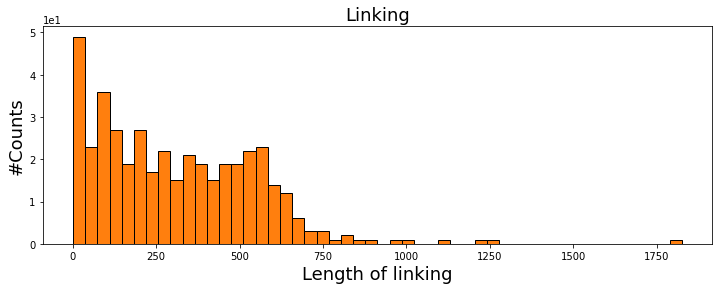

In [11]:
#Histogram of temporal length of particle trajectories
from matplotlib import pyplot
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np

his_all_particles = linked_PSFs['particle'].value_counts()
# For Jupyter notebooks only:
%matplotlib inline
fig = plt.figure(figsize=(12, 4))

plt.hist(his_all_particles, bins=50, fc='C1', ec='k', density=False)
plt.ylabel('#Counts', fontsize=18)
plt.xlabel('Length of linking', fontsize=18)
plt.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))  
plt.title('Linking', fontsize=18)
print('Median of linking length is {}'.format(np.median(his_all_particles)))
plt.show()

Spatial filtering of PSFs and temporal filtering of linked trajectories are done and the resultant data structure is printed below. 

In [12]:
from piscat.Localization import localization_filtering

# Spatial filters
spatial_filters = localization_filtering.SpatialFilter()
PSFs_filtered = spatial_filters.outlier_frames(linked_PSFs, threshold=20)
PSFs_filtered = spatial_filters.dense_PSFs(PSFs_filtered, threshold=0)
PSFs_filtered = spatial_filters.symmetric_PSFs(PSFs_filtered, threshold=0.7)

# Temporal filters
from piscat.Trajectory import TemporalFilter

t_filters = TemporalFilter(video=RVideo_PN, batchSize=batchSize)
all_trajectories, linked_PSFs_filter, his_all_particles = t_filters.v_trajectory(df_PSFs=PSFs_filtered, threshold=270)
    
# Printing results
PSFs.info()


start removing crappy frames ---> Done!

---Cleaning the df_PSFs that have drift without parallel loop---


  0%|          | 0/18359 [00:00<?, ?it/s]


Number of PSFs before filters = 115112

Number of PSFs after filters = 105370

start V_trajectories without parallel loop---> 

  0%|          | 0/140 [00:00<?, ?it/s]

Done
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131856 entries, 0 to 131855
Data columns (total 18 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   y                     131856 non-null  float64
 1   x                     131856 non-null  float64
 2   frame                 131856 non-null  float64
 3   center_intensity      131856 non-null  float64
 4   sigma                 131856 non-null  float64
 5   Sigma_ratio           131856 non-null  float64
 6   Fit_Amplitude         124098 non-null  float64
 7   Fit_X-Center          124098 non-null  float64
 8   Fit_Y-Center          124098 non-null  float64
 9   Fit_X-Sigma           124098 non-null  float64
 10  Fit_Y-Sigma           124098 non-null  float64
 11  Fit_Bias              124098 non-null  float64
 12  Fit_errors_Amplitude  123550 non-null  float64
 13  Fit_errors_X-Center   123965 non-null  float64
 14  Fit_errors_Y-Center   123929 non-null  float64


### Visualization of detected proteins before and after spatiotemporal filtering

In [13]:
from piscat.Visualization import JupyterPSFs_subplotLocalizationDisplay
JupyterPSFs_subplotLocalizationDisplay(list_videos=[RVideo_PN, RVideo_PN], list_df_PSFs=[PSFs_dog, linked_PSFs_filter], 
                                        numRows=1, numColumns=2, 
                                        list_titles=['Before Spatiotemporal filtering', 'After Spatiotemporal filtering'], 
                                        median_filter_flag=False, color='gray', imgSizex=15, imgSizey=15, 
                                        IntSlider_width='400px', step=1, value=0)

interactive(children=(IntSlider(value=0, continuous_update=False, description='Frame:', layout=Layout(width='4…

## Saving analysis results

In [14]:
from piscat.InputOutput import read_write_data
saving_directory = os.path.join(dir_path, 'Tutorials', 'Demo data','Histogram')
# Saving the filtered particles as an csv file
read_write_data.save_df2csv(linked_PSFs_filter, path=saving_directory, name='filtered_particles')
# Saving all the analysis done for the detected proteins as mat file to be used in matlab for further analysis
read_write_data.save_mat(all_trajectories, path=saving_directory, name='all_trajectories')
# Saving all the analysis results as HDF5 file to be used for example at a later stage for further analysis in PiSCAT
read_write_data.save_list_to_hdf5(all_trajectories, path=saving_directory, name='histogram_data')

## Loading results
In the following cell, we provide an example for loading previously saved results of data type of hdf5.

In [15]:
loading_directory = os.path.join(dir_path, 'Tutorials', 'Demo data','Histogram')
# Listing all the files which have HDF5 in the above directory
df_video = reading_videos.DirectoryType(loading_directory, type_file='h5').return_df()
paths = df_video['Directory'].tolist()
HDF5_names = df_video['File'].tolist()
# Choosing the first entry in the list to load 
hist_data_path = os.path.join(paths[0], HDF5_names[0])

from piscat.InputOutput import read_write_data
all_trajectories = read_write_data.load_dict_from_hdf5(hist_data_path)

## Estimation of the protein contrast
Once the trajectory of a protein landing or take-off event is built from the individual localization events, the central intensity value of the protein signal in each frame of the DRA video is extracted. This temporal trace can be used to estimate the contrast of the proteins. In the following, we provide two cells to demonstrate this analysis. The contrast estimation of a protein is illustrated in the first cell using the temporal intensity trace of the protein. The same protein is marked and visualized in the second cell where this overlay is done on the DRA videos. 

In the [contrast estimation class](https://piscat.readthedocs.io/en/latest/code_reference.html#piscat.Analysis.PlotProteinHistogram), we first extend the trace from the detected region (sandwiched between two vertical dashed lines) to grow to twice the batch size if possible. This extended trace is then smoothed using a windowing average which corresponds to 5% of the length of the trace. The mean of the signal at the detected region is computed. A positive mean value would mean the extremum is a maximum and vice versa. We then make sure that the extremum is always a peak from which we separate left and right arms of the signal. Each side of the arms is then separately fitted with a line. The intersection point of these lines can be used to read off the contrast value of the protein in addition to simply reading the peak value of the signal. In case the baseline of the intensity profiles are not symmetric or not zero-valued, one can take Prominence of the extrema as a measure of the contrast which is shown here with a vertical orange line.

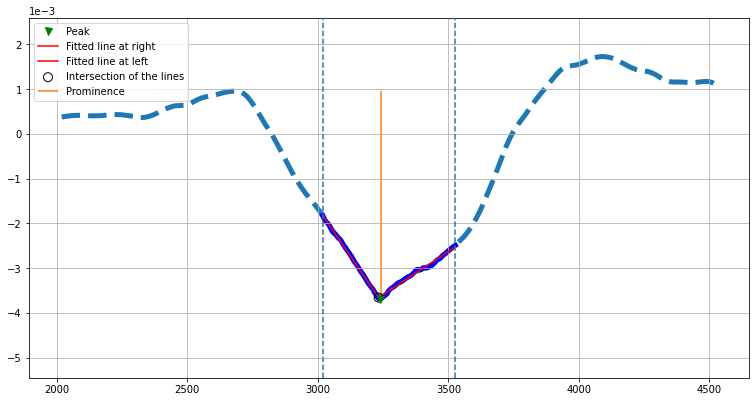

In [16]:
# The contrast estimation cell
from piscat.Analysis import PlotProteinHistogram
his_ = PlotProteinHistogram(intersection_display_flag=True, imgSizex=10, imgSizey=5)
his_.plot_contrast_extraction(particles=all_trajectories, batch_size=batchSize, video_frame_num=RVideo_PN.shape[0], MinPeakWidth=100,
                              MinPeakProminence=0, pixel_size=0.66, particles_num='#16')

In [17]:
# Marking and visualizing the detected proteins in the DRA videos, here the particle with ID number 16
from piscat.Visualization import JupyterSelectedPSFs_localizationDisplay

# For Jupyter notebooks only:
%matplotlib inline
JupyterSelectedPSFs_localizationDisplay(video=RVideo_PN, particles=all_trajectories, particles_num='#16', 
                                          frame_extend=0, median_filter_flag=True, 
                                          flag_fit2D=False, color='gray', imgSizex=15, imgSizey=15)

<Figure size 1080x1080 with 0 Axes>

interactive(children=(IntSlider(value=3019, continuous_update=False, description='Frame:', layout=Layout(width…

## Histogram of the protein contrasts
In the following cell, the distribution of the contrasts of the proteins (dark, bright and total) which were previously estimated using [three different methods of fitting, peak and prominence](Tutorial3.ipynb#Estimation-of-the-protein-contrast) are visualized in the histograms using the ([PlotProteinHistogram](https://piscat.readthedocs.io/en/latest/code_reference.html#piscat.Analysis.PlotProteinHistogram)) module. Here, we employ the Gaussian Mixture Model (GMM) as a well-established method for identifying the modes or components in a population as well as their features [[2]](https://www.annualreviews.org/doi/abs/10.1146/annurev-statistics-031017-100325).

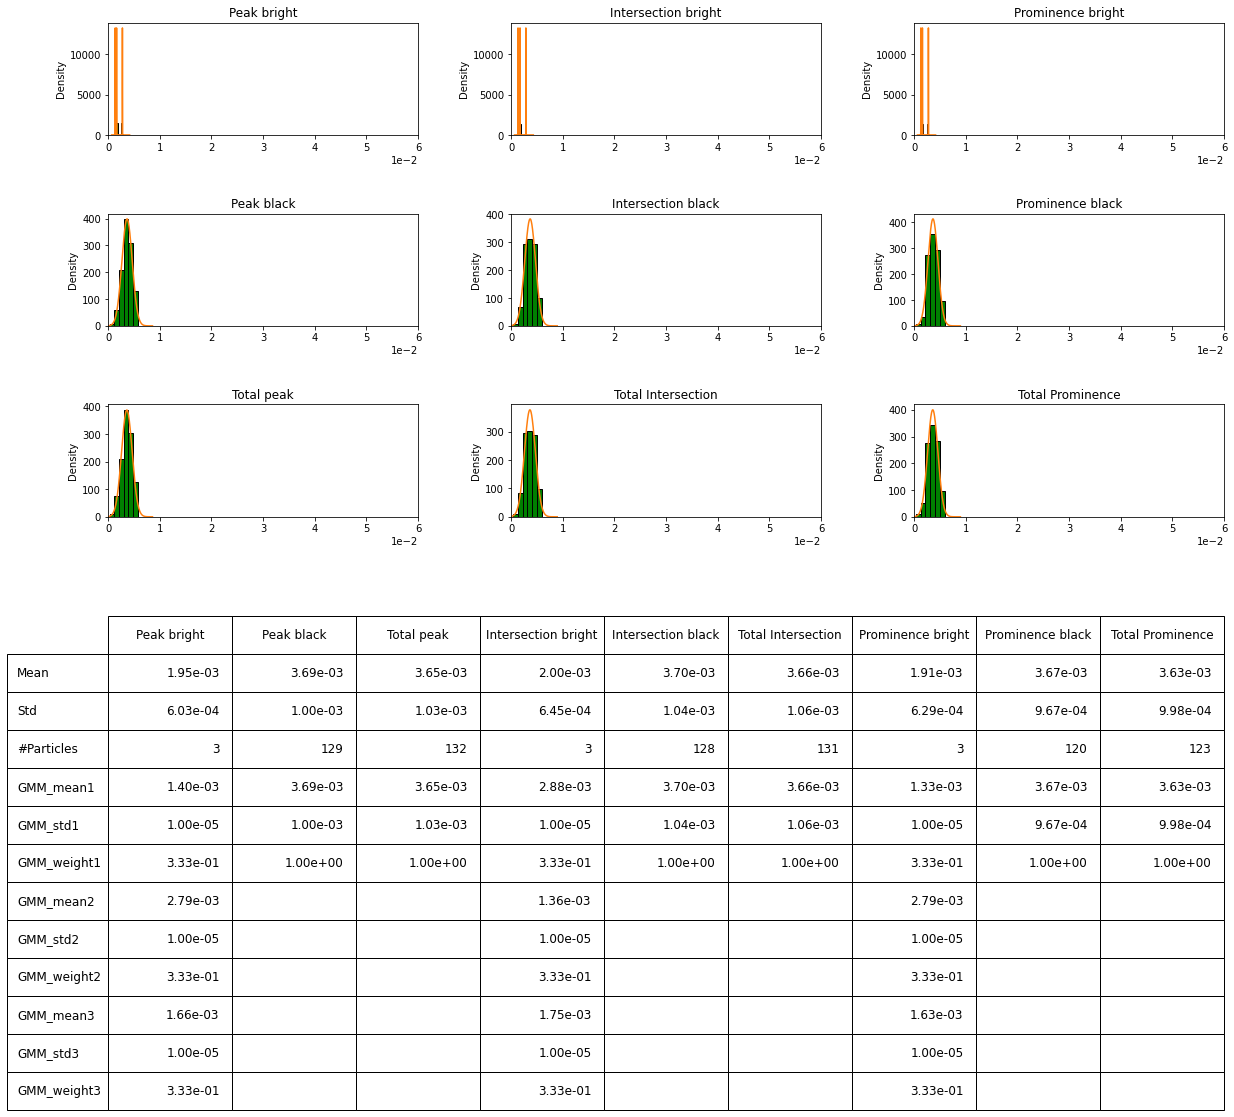

In [18]:
from piscat.Analysis import PlotProteinHistogram
# For Jupyter notebooks only:
%matplotlib inline

his_ = PlotProteinHistogram(intersection_display_flag=False)
his_(folder_name='', particles=all_trajectories, batch_size=batchSize, video_frame_num=RVideo_PN.shape[0], 
     MinPeakWidth=200, MinPeakProminence=0, pixel_size=0.66)
his_.plot_histogram(bins=6, upper_limitation=6e-3, lower_limitation=-6e-3, step_range=1e-6, face='g', 
                    edge='k', Flag_GMM_fit=True, max_n_components=3)

### Bibliography 
1. Kashkanova, Anna D., et al. “Precision single-particle localization using radial variance transform.” Optics Express 29.7 (2021): 11070-11083.
2. McLachlan, Geoffrey J., Sharon X. Lee, and Suren I. Rathnayake. "Finite mixture models." Annual review of statistics and its application 6 (2019): 355-378.